In [1]:
%load_ext autoreload
%autoreload 2
%cd ~/Research/Sriram/DeepSetRNN

import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import os
import string
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import logging
import os
import importlib

from src import convert_dot_format

DATA_PATH='data/MIMIC3database'

/home/minh/Research/Sriram/DeepSetRNN


In [2]:
logging.info("starting logger")
_LOGGER = logging.getLogger('MIMIC_seq_model')
_LOGGER.setLevel(logging.DEBUG)

In [3]:
diagnoses_procedures_df = pd.read_csv('data/MIMIC3database/processed/ICD9_diagnoses_procedures_mimic_idx_sentences.csv', index_col=0)

In [4]:
#only retaining top 100 diagnoses
diagnoses_counts = diagnoses_procedures_df['ICD9_CODE_diagnoses'].value_counts()
procedures_counts = diagnoses_procedures_df['ICD9_CODE_procedures'].value_counts()

k = 100
diagnoses_set = set(diagnoses_counts.keys()[:k])
procedures_set = set(procedures_counts.keys()[:k])

diagnoses_procedures_df = diagnoses_procedures_df[diagnoses_procedures_df['ICD9_CODE_diagnoses'].isin(diagnoses_set) 
                                                        | diagnoses_procedures_df['ICD9_CODE_procedures'].isin(procedures_set)]
diagnoses_procedures_df.to_csv('data/MIMIC3database/processed/ICD9_diagnoses_procedures_mimic_idx_sentences_top_{}.cs'.format(k))

In [5]:
#converting sentences to a single column
diagnoses_procedures_df['DIAGNOSES_SENTENCES'] = diagnoses_procedures_df[['0_diagnoses', '1_diagnoses',
       '2_diagnoses', '3_diagnoses', '4_diagnoses', '5_diagnoses',
       '6_diagnoses', '7_diagnoses', '8_diagnoses', '9_diagnoses',
       '10_diagnoses', '11_diagnoses', '12_diagnoses', '13_diagnoses',
       '14_diagnoses', '15_diagnoses', '16_diagnoses', '17_diagnoses',
       '18_diagnoses', '19_diagnoses', '20_diagnoses', '21_diagnoses', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31']].values.tolist()

diagnoses_procedures_df['PROCEDURES_SENTENCES'] = diagnoses_procedures_df[
    ['0_procedures', '1_procedures', '2_procedures', '3_procedures',
       '4_procedures', '5_procedures', '6_procedures', '7_procedures',
       '8_procedures', '9_procedures', '10_procedures', '11_procedures',
       '12_procedures', '13_procedures', '14_procedures', '15_procedures',
       '16_procedures', '17_procedures', '18_procedures', '19_procedures',
       '20_procedures', '21_procedures']].values.tolist()

In [6]:
data = list(diagnoses_procedures_df.groupby(['SUBJECT_ID']))
data = [(subject_id, list(subject_data.groupby(['HADM_ID', 'ADMITTIME']))) for subject_id, subject_data in data]

In [7]:
inputs = []
for _, subject in data:
    series = []
    for _, timestep in subject:
        timestep = timestep[timestep['ICD9_CODE_diagnoses'].isin(diagnoses_set)
                           | timestep['ICD9_CODE_procedures'].isin(procedures_set)]
        if len(timestep) > 0:
            series.append((np.stack(timestep['DIAGNOSES_SENTENCES'],axis=0), np.stack(timestep['PROCEDURES_SENTENCES'],axis=0)))
        #for _, timestep in timesteps:
        #    print(timestep)
    if len(series) > 0:
        inputs.append(series)

In [8]:
diagnoses_idx_map = {}

for i, code in enumerate(diagnoses_counts.keys()[:k]):
    diagnoses_idx_map[code] = i

In [9]:
diagnoses_counts.keys()[:k]
outputs = []

def get_onehot_vector(indices, k):
    prediction = np.zeros(k, dtype='float32')
    prediction[indices] = 1
    return prediction

for _, subject in data:
    series = []
    for _, timestep in subject:
        indices = [diagnoses_idx_map[key] for key in timestep['ICD9_CODE_diagnoses'] \
                  if key in diagnoses_set]
        series.append(get_onehot_vector(indices, k))
    outputs.append(np.array(series))
#outputs = list(map(get_key, outputs))

In [10]:
min_len = 3

all_inputs = inputs
all_outputs = outputs

inputs = list(filter(lambda x : len(x) >= min_len, all_inputs))
outputs = list(filter(lambda x: len(x) >= min_len, all_outputs))

n_seq = len(inputs)

split = int(n_seq*0.8)
train_inputs = inputs[:split]
train_outputs =  outputs[:split]

test_inputs = inputs[split:n_seq]
test_outputs = outputs[split:n_seq]

In [ ]:
len(inputs)

In [11]:
word_embedding = pd.read_csv('data/embeddings/w2vModel1Gram9Jan2019_mimic_only.txt', index_col=0)
word_embedding.drop('0',axis=1,inplace=True)
word_embedding = torch.tensor(word_embedding.astype('float32').values)

In [12]:
#MODEL DEFINITION
from src.model.mimic_deepset import SetSequenceModel

n_diagnoses = k
hidden_dim=[1000,100]
n_epoch = 10
freeze_embedding = True

_LOGGER.handlers = [
    h for h in _LOGGER.handlers if not isinstance(h, logging.StreamHandler)]
model_name = "diagnoses_classifier_top_{}_{}hd_{}".format(k, hidden_dim, n_epoch)
fh = logging.FileHandler('logs/MIMIC3/{}.log'.format(model_name))
fh.setLevel(logging.DEBUG)
_LOGGER.addHandler(fh)

loss_fn = nn.BCEWithLogitsLoss()
model = SetSequenceModel(hidden_dim=hidden_dim, n_class=n_diagnoses,embedding=word_embedding, freeze_embedding=freeze_embedding)

In [15]:
test_losses = []
for sequence, target in zip(test_inputs, test_outputs):
    model.hidden = model.init_hidden()
    logits = model(sequence)
    
    loss = loss_fn(logits[:-1],torch.tensor(target[1:]))
    test_losses.append(loss.data)
_LOGGER.info("Validation Loss: {}".format(np.mean(test_losses)))

INFO:MIMIC_seq_model:Validation Loss: 0.692812442779541


In [16]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=.9)
losses = []


for epoch in range(n_epoch):
    curr_losses = []
    for sequence, target in zip(train_inputs,
                                train_outputs):
        model.zero_grad()
        model.hidden = model.init_hidden()
        
        logits = model(sequence)
        loss = loss_fn(logits[1:], torch.tensor(target[1:]))
        curr_losses.append(loss.data)
        loss.backward()
        optimizer.step()
    mean_loss = np.mean(curr_losses)
    losses.append(mean_loss)
    _LOGGER.info("epoch {}: {}".format(epoch, mean_loss))

INFO:MIMIC_seq_model:epoch 0: 0.21778380870819092
INFO:MIMIC_seq_model:epoch 1: 0.17794924974441528
INFO:MIMIC_seq_model:epoch 2: 0.15421701967716217
INFO:MIMIC_seq_model:epoch 3: 0.13635408878326416
INFO:MIMIC_seq_model:epoch 4: 0.1224445030093193
INFO:MIMIC_seq_model:epoch 5: 0.11081551015377045
INFO:MIMIC_seq_model:epoch 6: 0.09973505884408951
INFO:MIMIC_seq_model:epoch 7: 0.09157151728868484
INFO:MIMIC_seq_model:epoch 8: 0.08456550538539886
INFO:MIMIC_seq_model:epoch 9: 0.07857616990804672


In [19]:
test_losses = []
for sequence, target in zip(test_inputs, test_outputs):
    model.hidden = model.init_hidden()
    logits = model(sequence)
    loss = loss_fn(logits[:-1],torch.tensor(target[1:]))
    test_losses.append(loss.data)
_LOGGER.info("final validation Loss: {}".format(np.mean(test_losses)))

INFO:MIMIC_seq_model:final validation Loss: 0.36749565601348877


In [20]:
#saving model
torch.save(model, 'models/MIMIC3/{}.pt'.format(model_name))

In [12]:
model = torch.load('models/MIMIC3/diagnoses_classifier_top_100_[1000, 100]hd_10.pt')

In [13]:
sigmoid = nn.Sigmoid()
test_model_outputs = []
all_logits = []
predictions = []
for sequence, target in zip(test_inputs, test_outputs):
    model.hidden = model.init_hidden()
    logits = model(sequence)
    #loss = loss_fn(logits[:-1],torch.tensor(target[1:]))
    #test_losses.append(loss.data)
    model_output = sigmoid(logits).detach().numpy()
    prediction = model_output > 0.5
    prediction = prediction.astype(np.float32)
    all_logits.append(logits.detach().numpy())
    test_model_outputs.append(model_output)
    predictions.append(prediction)

In [18]:
#k at
from src.utils import precision_at_k
k = 1
precisions_at_k = []
for logit, true_output in zip(all_logits, test_outputs):
    precisions_at_k.append(precision_at_k(logit[:-1], true_output[1:], k))

print(np.mean(precisions_at_k))

0.58153254


In [19]:
#confidence interval
k = 1
n_bootstrap = 1000
n_samples = 1000
from sklearn.utils import resample
from src.utils import precision_at_k

bootstrap_ks = []
for _ in range(n_bootstrap):
    bootstrap_logits, bootstrap_outputs = resample(all_logits, test_outputs, n_samples=n_samples)
    precisions_at_k = []
    for logit, true_output in zip(bootstrap_logits, bootstrap_outputs):
        precisions_at_k.append(precision_at_k(logit[:-1], true_output[1:], k))
    bootstrap_ks.append(np.mean(precisions_at_k))
bootstrap_ks = bootstrap_ks[1:]

In [20]:
import numpy as np, scipy.stats as st

st.t.interval(0.95, len(bootstrap_ks)-1, loc=np.mean(bootstrap_ks), scale=st.sem(bootstrap_ks))

(0.5810486950624776, 0.5824855885755229)

(array([  5.,  13.,  58., 181., 239., 251., 160.,  67.,  21.,   4.]),
 array([0.5427359 , 0.55050105, 0.5582662 , 0.5660314 , 0.5737966 ,
        0.5815618 , 0.589327  , 0.59709215, 0.6048573 , 0.6126225 ,
        0.6203877 ], dtype=float32),
 <a list of 10 Patch objects>)

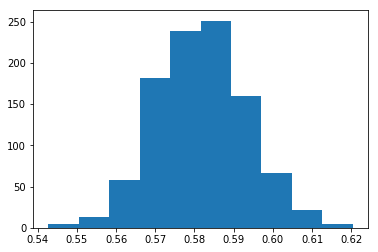

In [21]:
plt.hist(bootstrap_ks,bins=20 )

In [92]:
########5 minutes model##########
#preprocessing inputs to matrix


#logistic regression
from src.model.mimic_deepset import FullyConnectedNetworkClassifier

model = FullyConnectedNetworkClassifier(100, word_embedding, [1000, 100])
loss_fn = nn.BCEWithLogitsLoss()

In [93]:
test_losses = []
for sequence, target in zip(test_inputs, test_outputs):
    logits = model(sequence)
    
    loss = loss_fn(logits[:-1],torch.tensor(target[1:]))
    test_losses.append(loss.data)
_LOGGER.info("Validation Loss: {}".format(np.mean(test_losses)))

INFO:MIMIC_seq_model:Validation Loss: 0.6941178441047668


In [102]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=.9)
losses = []
n_epoch=5

for epoch in range(n_epoch):
    curr_losses = []
    for sequence, target in zip(train_inputs,
                                train_outputs):
        model.zero_grad()
        
        logits = model(sequence)
        loss = loss_fn(logits[1:], torch.tensor(target[1:]))
        curr_losses.append(loss.data)
        loss.backward()
        optimizer.step()
    mean_loss = np.mean(curr_losses)
    losses.append(mean_loss)
    _LOGGER.info("epoch {}: {}".format(epoch, mean_loss))

INFO:MIMIC_seq_model:epoch 0: 0.10724962502717972
INFO:MIMIC_seq_model:epoch 1: 0.10362500697374344
INFO:MIMIC_seq_model:epoch 2: 0.09642152488231659
INFO:MIMIC_seq_model:epoch 3: 0.09299089759588242
INFO:MIMIC_seq_model:epoch 4: 0.09194406121969223


In [103]:
test_losses = []
for sequence, target in zip(test_inputs, test_outputs):
    logits = model(sequence)
    
    loss = loss_fn(logits[:-1],torch.tensor(target[1:]))
    test_losses.append(loss.data)
_LOGGER.info("Validation Loss: {}".format(np.mean(test_losses)))

INFO:MIMIC_seq_model:Validation Loss: 0.417359858751297


In [104]:
sigmoid = nn.Sigmoid()
test_model_outputs = []
all_logits = []
predictions = []
for sequence, target in zip(test_inputs, test_outputs):
    logits = model(sequence)
    #loss = loss_fn(logits[:-1],torch.tensor(target[1:]))
    #test_losses.append(loss.data)
    model_output = sigmoid(logits).detach().numpy()
    prediction = model_output > 0.5
    prediction = prediction.astype(np.float32)
    all_logits.append(logits.detach().numpy())
    test_model_outputs.append(model_output)
    predictions.append(prediction)

In [105]:
#confidence interval
k = 1
n_bootstrap = 1000
from sklearn.utils import resample
from src.utils import precision_at_k

precisions_at_k = []
for logit, true_output in zip(all_logits, test_outputs):
    precisions_at_k.append(precision_at_k(logit[:-1], true_output[1:], k))

bootstrapped_paks = [np.mean(resample(precisions_at_k)) for _ in range(n_bootstrap)]

In [106]:
import numpy as np, scipy.stats as st

st.t.interval(0.95, len(bootstrapped_paks)-1, loc=np.mean(bootstrapped_paks), scale=st.sem(bootstrap_ks))

(0.5844169880107548, 0.5864697669788692)

(array([  4.,   3.,  12.,  19.,  34.,  53., 107., 132., 120., 135., 135.,
         84.,  79.,  47.,  17.,  11.,   2.,   3.,   2.,   1.]),
 array([0.5296049 , 0.535742  , 0.541879  , 0.5480161 , 0.55415314,
        0.5602902 , 0.56642723, 0.5725643 , 0.5787014 , 0.5848384 ,
        0.59097546, 0.59711254, 0.60324955, 0.6093866 , 0.6155237 ,
        0.6216607 , 0.6277978 , 0.63393486, 0.6400719 , 0.64620894,
        0.652346  ], dtype=float32),
 <a list of 20 Patch objects>)

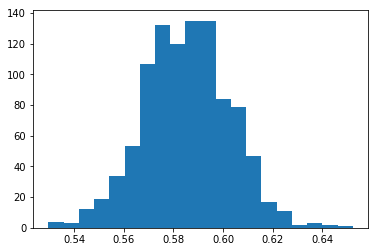

In [107]:
plt.hist(bootstrapped_paks, bins=20)

In [108]:
predictions_flattened = np.concatenate([prediction[:-1] for prediction in predictions]).flatten()
true_labels_flattened = np.concatenate([test_output[1:] for test_output in test_outputs]).flatten()

In [109]:
metrics.confusion_matrix(true_labels_flattened, predictions_flattened)

array([[108635,   3874],
       [  6650,   3141]])